In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import fredapi as fd
import plotly.express as px


from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics


import yfinance as yf
import datetime as dt

import seaborn as sns


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score






# Getting the CPI and Generating Headline Inflation.

This dataset was obtained from stats SA https://www.statssa.gov.za/?page_id=1847

In [257]:
# This 
inflation  = pd.read_csv('Data/CSVHistorical CPI.csv')

In [258]:
# Going to nowcast for the urban areas CPI
AllUrbanAreas = inflation[inflation['H13'] == 'All urban areas']
AllUrbanAreas

,H01,H02,H03,H04,H05,H06,H13,H17,H18,H24,...,MO042024,MO052024,MO062024,MO072024,MO082024,MO092024,MO102024,MO112024,MO122024,MO012025
2,P0141,Consumer Price Index,CPI60065,Analytical series - All urban areas,CPI for pensioners,NaN,All urban areas,Index,Dec 2024 = 100,2008 01,...,98.6,98.8,98.9,99.6,99.7,99.8,99.9,99.9,100,100.2
12,P0141,Consumer Price Index,CPS00000,CPI Headline,NaN,NaN,All urban areas,Index,Dec 2024 = 100,2008 01,...,99.1,99.3,99.4,99.8,99.9,100.0,99.9,99.9,100,100.3
13,P0141,Consumer Price Index,CPSD0001,Deciles - All urban areas,Expenditure deciles,1.0,All urban areas,Index,Dec 2024 = 100,2017 01,...,97.2,97.5,97.7,99.6,99.8,100.1,100.3,100.0,100,100.4
14,P0141,Consumer Price Index,CPSD0002,Deciles - All urban areas,Expenditure deciles,2.0,All urban areas,Index,Dec 2024 = 100,2017 01,...,97.6,97.9,98.1,99.6,99.8,100.0,100.2,100.0,100,100.3
15,P0141,Consumer Price Index,CPSD0003,Deciles - All urban areas,Expenditure deciles,3.0,All urban areas,Index,Dec 2024 = 100,2017 01,...,98.0,98.2,98.5,99.5,99.6,99.9,100.0,99.8,100,100.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,P0141,Consumer Price Index,CPS11211,Education services,University boarding fees,NaN,All urban areas,Index,Dec 2024 = 100,2008 01,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0
785,P0141,Consumer Price Index,CPS00023,Education services,Education including boarding fees,NaN,All urban areas,Index,Dec 2024 = 100,2008 01,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0
786,P0141,Consumer Price Index,CPS07101,Vehicles,New vehicles,NaN,All urban areas,Index,Dec 2024 = 100,2008 01,...,98.3,98.9,98.9,99.2,99.3,99.3,99.6,99.9,100,100.6
787,P0141,Consumer Price Index,CPS07102,Vehicles,Used vehicles,NaN,All urban areas,Index,Dec 2024 = 100,2008 01,...,101.0,101.0,100.9,100.9,100.7,100.6,100.5,100.3,100,99.9


In [259]:

# List of the category codes you want to keep
category_codes = [
    "CPS00000", "CPS01000", "CPS02000", "CPS03000", "CPS04000", 
    "CPS05000", "CPS06000", "CPS07000", "CPS08000", "CPS09000", 
    "CPS10000", "CPS11000", "CPS12000"
]

# Assuming your DataFrame is called df
AllUrbanAreas = AllUrbanAreas[AllUrbanAreas['H03'].isin(category_codes)]
AllUrbanAreas = AllUrbanAreas[AllUrbanAreas['H04'] != 'All Items']
AllUrbanAreas = AllUrbanAreas.reset_index(drop=True)

# List of columns you want to drop
columns_to_drop = ['H01', 'H05', 'H06','H17','H18','H25','H02','H03','H13','H24']

# Drop the specified columns from the DataFrame
AllUrbanAreas = AllUrbanAreas.drop(columns=columns_to_drop)

In [260]:
# transpose the Dataframe and reset the index
pivoted_df = AllUrbanAreas.set_index('H04').transpose()

# setting the index to date: 

# Remove the 'MO' prefix from the index
pivoted_df['Date'] = pd.to_datetime(pivoted_df.index.str[2:], format='%m%Y')

pivoted_df.reset_index(drop=True, inplace=True)

In [261]:
CPI = pivoted_df[['Date','CPI Headline']]

In [262]:
CPI['MonthInflation'] = CPI['CPI Headline'].pct_change()*100
CPI['YearInflation'] = CPI['CPI Headline'].pct_change(12)*100

/var/folders/20/l853m0wd02b4mwcklpnsdqx40000gn/T/ipykernel_49156/636628538.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/20/l853m0wd02b4mwcklpnsdqx40000gn/T/ipykernel_49156/636628538.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Investigating Alternative Inflation Forecasting Models

This is going to be a **toy model** and more of a **Sunday night experiment**. Instead of using the **STATS SA CPI dataset**, we’ll be using **alternative datasets** to forecast the **CPI index**, investigating whether these other features have **predictive power** in modeling inflation.

Most traditional inflation forecasting methods rely on the **direct forecasting approach**, which uses available data to predict inflation without depending on future information. We’ll apply **standard forecasting models** (such as **ARIMA, SARIMA, VAR, and Prophet**) to test how well **non-STATS SA data** can predict CPI trends.

The idea is to explore whether **external macroeconomic indicators, financial data, or alternative datasets** can serve as **strong predictors of inflation**—without relying on the **official CPI dataset components**. If this approach proves effective, it could highlight **alternative signals** that drive inflationary trends.

We have **CPI data spanning from 2008-01-01 to 2025-01-01**, and we'll apply these forecasting models to see which **alternative datasets** offer meaningful predictive insights.

## Reference  
[Big Data Forecasting of South African Inflation - South African Reserve Bank](https://www.resbank.co.za/en/home/publications/publication-detail-pages/working-papers/2022/big-data-forecasting-of-south-african-inflation)


In [263]:
# Calculating the monthly and yearly inflation rates
CPI = pivoted_df[['Date','CPI Headline']]
CPI['MonthInflation'] = CPI['CPI Headline'].pct_change()*100
CPI['YearInflation'] = CPI['CPI Headline'].pct_change(12)*100
CPI.tail(20)

/var/folders/20/l853m0wd02b4mwcklpnsdqx40000gn/T/ipykernel_49156/1312178696.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/20/l853m0wd02b4mwcklpnsdqx40000gn/T/ipykernel_49156/1312178696.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



H04,Date,CPI Headline,MonthInflation,YearInflation
185,2023-06-01,94.6,0.211864,5.345212
186,2023-07-01,95.4,0.845666,4.720088
187,2023-08-01,95.7,0.314465,4.819277
188,2023-09-01,96.3,0.626959,5.361050
189,2023-10-01,97.2,0.934579,5.997819
190,2023-11-01,97.1,-0.102881,5.543478
191,2023-12-01,97.1,0.000000,5.200433
192,2024-01-01,97.2,0.102987,5.422993
193,2024-02-01,98.1,0.925926,5.597417
194,2024-03-01,98.9,0.815494,5.324814


## 1st Dataset: Historical GPD

Data will be downloaded from the Federal Reserve Bank of St. Louis
https://fred.stlouisfed.org/series/NGDPRSAXDCZAQ


In [264]:

fred = fd.Fred(api_key='56573fff95fcef94dc89f1dfef310615')

In [265]:
data = fred.search('Real Gross Domestic Product for South Africa')
data

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
NGDPRSAXDCZAQ,NGDPRSAXDCZAQ,2025-03-09,2025-03-09,Real Gross Domestic Product for South Africa,1993-01-01,2024-07-01,Quarterly,Q,Millions of Domestic Currency,Mil. of Domestic Currency,Seasonally Adjusted,SA,2024-12-30 08:41:03-06:00,36,None
ZAFNGDPRPCPPPT,ZAFNGDPRPCPPPT,2025-03-09,2025-03-09,Real Gross Domestic Product for South Africa,2000-01-01,2025-01-01,Annual,A,Percent Change From Preceding Period,% Chg. From Preceding Period,Not Seasonally Adjusted,NSA,2024-10-25 15:29:03-05:00,18,Observations for the current and future years ...
NGDPRNSAXDCZAQ,NGDPRNSAXDCZAQ,2025-03-09,2025-03-09,Real Gross Domestic Product for South Africa,1993-01-01,2024-07-01,Quarterly,Q,Millions of Domestic Currency,Mil. of Domestic Currency,Not Seasonally Adjusted,NSA,2024-12-30 08:40:07-06:00,6,None
NGDPRXDCZAA,NGDPRXDCZAA,2025-03-09,2025-03-09,Real Gross Domestic Product for South Africa,1993-01-01,2023-01-01,Annual,A,Millions of Domestic Currency,Mil. of Domestic Currency,Not Seasonally Adjusted,NSA,2024-07-22 08:39:18-05:00,3,None
ZAFNGDPRPCPCPPPT,ZAFNGDPRPCPCPPPT,2025-03-09,2025-03-09,Real GDP Per Capita for South Africa,2000-01-01,2025-01-01,Annual,A,Percent Change From Preceding Period,% Chg. From Preceding Period,Not Seasonally Adjusted,NSA,2024-10-25 15:29:03-05:00,21,Observations for the current and future years ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NAEXKP07ZAQ661S,NAEXKP07ZAQ661S,2025-03-09,2025-03-09,National Accounts: GDP by Expenditure: Constan...,1960-01-01,2023-07-01,Quarterly,Q,Index 2015=100,Index 2015=100,Seasonally Adjusted,SA,2024-01-12 14:37:29-06:00,0,OECD Descriptor ID: NAEXKP07 OECD unit ID: IDX...
ZAFNGDPXORPCPPPT,ZAFNGDPXORPCPPPT,2025-03-09,2025-03-09,Real Non-Oil GDP for South Africa,2000-01-01,2025-01-01,Annual,A,Percent Change From Preceding Period,% Chg. From Preceding Period,Not Seasonally Adjusted,NSA,2024-10-25 15:30:56-05:00,0,Observations for the current and future years ...
CGDPESZAA666NRUG,CGDPESZAA666NRUG,2025-03-09,2025-03-09,Expenditure-side Real GDP at Current Purchasin...,1950-01-01,2019-01-01,Annual,A,Millions of 2017 U.S. Dollars,Mil. of 2017 U.S. $,Not Seasonally Adjusted,NSA,2021-11-08 13:33:25-06:00,0,Source ID: cgdpe When using these data in you...


In [266]:
GDP = fred.get_series('NGDPRSAXDCZAQ')
GDP

1993-01-01    5.709373e+05
1993-04-01    5.748354e+05
1993-07-01    5.822070e+05
1993-10-01    5.871761e+05
1994-01-01    5.868994e+05
                  ...     
2023-07-01    1.156701e+06
2023-10-01    1.160715e+06
2024-01-01    1.161049e+06
2024-04-01    1.165044e+06
2024-07-01    1.161002e+06
Length: 127, dtype: float64

In [267]:
GDP = pd.DataFrame(GDP).reset_index()
GDP.columns = ['Date', 'GDP']  # Rename columns
GDP

,Date,GDP
0,1993-01-01,5.709373e+05
1,1993-04-01,5.748354e+05
2,1993-07-01,5.822070e+05
3,1993-10-01,5.871761e+05
4,1994-01-01,5.868994e+05
...,...,...
122,2023-07-01,1.156701e+06
123,2023-10-01,1.160715e+06
124,2024-01-01,1.161049e+06
125,2024-04-01,1.165044e+06


We see here that we have data until 07-2024. 

## 2nd: South African Reserve Bank

Obtained from https://www.resbank.co.za/en/home/what-we-do/statistics/key-statistics/selected-historical-rates


### USD - ZAR Pound - ZAR

In [268]:
USD = pd.read_csv('Data/HistoricalRateDetailUSD.csv')
USD = USD.drop(index=USD.index[:3])
USD = USD.rename(columns={'Indicator':'Date', 'Description':'USD'})

Pound = pd.read_csv('Data/HistoricalRateDetailPound.csv')
Pound = Pound.drop(index=Pound.index[:3])
Pound = Pound.rename(columns={'Indicator':'Date', 'Description':'Pound'})


In [269]:
Repo = pd.read_csv('Data/Repo Rate.csv')
Repo = Repo.drop(index=Repo.index[:3])
Repo = Repo.rename(columns={'Indicator':'Date', 'Description':'RepoRate'})



In [270]:
Prime = pd.read_csv('Data/Prime.csv')
Prime = Prime.drop(index=Prime.index[:3])
Prime = Prime.rename(columns={'Indicator':'Date', 'Description':'Prime'})


In [271]:
merged = Pound.merge(USD,  on = 'Date')
merged = merged.merge(Repo, on = 'Date')
merged = merged.merge(Prime, on = 'Date')
merged

,Date,Pound,USD,RepoRate,Prime
0,2025-03-07,23.3678,18.0809,7.5,11
1,2025-03-06,23.6894,18.3625,7.5,11
2,2025-03-05,23.6623,18.4178,7.5,11
3,2025-03-04,23.6356,18.5851,7.5,11
4,2025-03-03,23.5331,18.6964,7.5,11
...,...,...,...,...,...
5785,2002-01-08,16.7245,11.6118,9.5,13
5786,2002-01-07,17.2577,11.9336,9.5,13
5787,2002-01-04,17.3253,12.0381,9.5,13
5788,2002-01-03,18.1156,12.5359,9.5,13


## 3rd: JSE Returns

In [272]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    return returns

In [273]:
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=7300)


In [274]:
returns = getData('JSE.JO', start=startDate, end=endDate)

[*********************100%***********************]  1 of 1 completed


In [275]:
returns = returns.dropna()
returns = returns.reset_index()

returns

Ticker,Date,JSE.JO
0,2006-06-06,-0.093196
1,2006-06-07,-0.049568
2,2006-06-08,-0.043062
3,2006-06-09,0.150000
4,2006-06-12,-0.069565
...,...,...
4774,2025-03-03,0.020489
4775,2025-03-04,0.024998
4776,2025-03-05,0.018040
4777,2025-03-06,-0.011256


## 4th Dataset: Electricity Production 

Obtained from https://www.resbank.co.za


In [276]:
electricity = pd.read_csv('Data/electricity.csv')

In [277]:
electricity = electricity[electricity['H04'].isin(['Total - All producers'])]
electricity.loc[(electricity['H05'] == 'Electricity available for distribution in South Africa') & (electricity['H16'] == 'Seasonally adjusted'), 'H05'] = 'Electricity available for distribution in South Africa - Seasonally Adjusted'
columns_to_drop = ['H01', 'H02', 'H03','H04','H13','H14','H16','H03','H17','H18','H25']
electricity = electricity.drop(columns=columns_to_drop)
electricity = electricity.set_index('H05').transpose()
electricity['Date'] = pd.to_datetime(electricity.index.str[2:], format='%m%Y')
electricity.reset_index(drop=True, inplace=True)


electricity

H05,Electricity available for distribution in South Africa - Seasonally Adjusted,Electricity produced,Purchased outside South Africa (import),Consumed in power stations and auxiliary systems,Sold outside South Africa (export),Electricity available for distribution in South Africa,Date
0,15916.0,16239.0,683.0,1212.0,197.0,15512.0,2000-01-01
1,15981.0,16008.0,529.0,1145.0,169.0,15224.0,2000-02-01
2,16106.0,17722.0,6.0,1306.0,196.0,16225.0,2000-03-01
3,16347.0,16831.0,24.0,1300.0,155.0,15399.0,2000-04-01
4,16329.0,18656.0,20.0,1399.0,213.0,17064.0,2000-05-01
...,...,...,...,...,...,...,...
296,18000.0,19942.0,628.0,1539.0,1307.0,17723.0,2024-09-01
297,17809.0,20385.0,660.0,1562.0,1388.0,18094.0,2024-10-01
298,17798.0,19764.0,602.0,1444.0,1502.0,17419.0,2024-11-01
299,17638.0,18961.0,776.0,1396.0,1475.0,16865.0,2024-12-01


## 5th Dataset: Liquidations

Obtained from https://www.resbank.co.za


In [278]:
Liquidations = pd.read_csv('Data/Liquidations.csv')
Liquidations = Liquidations[Liquidations['H06'] == 'Total']
columns_to_drop = ['H01', 'H02', 'H03','H04','H06','H07','H16','H17','H25']
Liquidations = Liquidations.drop(columns=columns_to_drop)
Liquidations = Liquidations.set_index('H05').transpose()
Liquidations['Date'] = pd.to_datetime(Liquidations.index.str[2:], format='%m%Y')
Liquidations.reset_index(drop=True, inplace=True)

Liquidations


H05,Companies,Close corporations,Date
0,91,102,2000-01-01
1,151,78,2000-02-01
2,241,85,2000-03-01
3,166,107,2000-04-01
4,130,128,2000-05-01
...,...,...,...
296,60,57,2024-09-01
297,107,89,2024-10-01
298,78,50,2024-11-01
299,46,44,2024-12-01


# Merging All Datasets and Performing Analysis

In [279]:
merged['Date'] = pd.to_datetime(merged['Date'])


In [280]:
merged = merged.merge(returns, on = 'Date')
merged = merged.merge(CPI, on = 'Date')
merged = merged.merge(electricity, on = 'Date')
merged = merged.merge(Liquidations, on = 'Date')
merged

,Date,Pound,USD,RepoRate,Prime,JSE.JO,CPI Headline,MonthInflation,YearInflation,Electricity available for distribution in South Africa - Seasonally Adjusted,Electricity produced,Purchased outside South Africa (import),Consumed in power stations and auxiliary systems,Sold outside South Africa (export),Electricity available for distribution in South Africa,Companies,Close corporations
0,2024-11-01,22.7869,17.6574,8,11.5,0.008934,99.9,0.000000,2.883625,17798.0,19764.0,602.0,1444.0,1502.0,17419.0,78,50
1,2024-10-01,23.044,17.2789,8,11.5,-0.012786,99.9,-0.100000,2.777778,17809.0,20385.0,660.0,1562.0,1388.0,18094.0,107,89
2,2024-08-01,23.3361,18.2555,8.25,11.75,0.006573,99.9,0.100200,4.388715,17973.0,20898.0,823.0,1719.0,1204.0,18800.0,62,66
3,2024-07-01,23.1762,18.3232,8.25,11.75,-0.008736,99.8,0.402414,4.612159,18188.0,21581.0,830.0,1748.0,1111.0,19552.0,76,57
4,2024-03-01,24.2964,19.2279,8.25,11.75,0.020196,98.9,0.815494,5.324814,17488.0,19160.0,822.0,1525.0,951.0,17506.0,66,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2008-09-01,13.9429,7.7272,12,15.5,0.009524,45.0,0.446429,NaN,20019.0,21384.0,1044.0,1500.0,1203.0,19725.0,177,151
115,2008-08-01,14.512,7.3464,12,15.5,-0.016043,44.8,0.674157,NaN,19902.0,22508.0,1076.0,1627.0,1220.0,20736.0,98,187
116,2008-07-01,15.7069,7.8637,12,15.5,-0.009174,44.5,1.366743,NaN,20092.0,23498.0,1089.0,1728.0,1249.0,21610.0,170,150
117,2008-04-01,16.0425,8.1207,11,14.5,0.000000,43.0,0.467290,NaN,19949.0,20813.0,844.0,1531.0,998.0,19127.0,104,143


## Exploring the feature correlations. 

These Two Functions Just allow us to look at Metrics

In [281]:
def CreateRadarChart(attributes, df):
    # The first attribute in the list will be used as the label
    label = attributes[0]

    # Compute Pearson and Spearman correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    corr_matrix_spearman = df[attributes].corr(method='spearman')

    # Get the top 6 correlation values based on absolute values for the specified label (first attribute in the list)
    pearson_values = corr_matrix_pearson[label].apply(abs).sort_values(ascending=False).head(7).values[1:]  # Excluding the label itself
    spearman_values = corr_matrix_spearman[label].apply(abs).sort_values(ascending=False).head(7).values[1:]

    # Labels for the radar chart (sorted based on absolute Pearson correlation)
    labels = corr_matrix_pearson[label].apply(abs).sort_values(ascending=False).head(7).index.tolist()[1:]  # Excluding the label itself

    # Make the radar chart 'close to a circle'
    pearson_values = np.concatenate((pearson_values, [pearson_values[0]]))
    spearman_values = np.concatenate((spearman_values, [spearman_values[0]]))
    
    # Number of variables (Top 6 features)
    num_vars = len(labels)

    # Compute angle for each axis of the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Add the first angle to make the chart 'close to a circle' 
    angles += angles[:1]

    # Set up the figure
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100, subplot_kw=dict(polar=True))

    # Plot data
    ax.plot(angles, pearson_values, color='blue', linewidth=2, label='Pearson Correlation (Abs)')
    ax.fill(angles, pearson_values, color='blue', alpha=0.25)

    ax.plot(angles, spearman_values, color='red', linewidth=2, label='Spearman Correlation (Abs)')
    ax.fill(angles, spearman_values, color='red', alpha=0.25)

    # Labels and title
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, rotation=45, ha='right')

    plt.title(f"Top 6 Absolute Correlations for {label}: Pearson vs. Spearman", size=16)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()

In [282]:
def CorrelationCreation(attributes, df):
    # Compute Pearson and Spearman correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    corr_matrix_spearman = df[attributes].corr(method='spearman')

    # Print Pearson correlation for the first attribute
    print("\nPearson Correlation")
    print(corr_matrix_pearson[attributes[0]].sort_values(ascending=False))

    # Print Spearman correlation for the first attribute
    print("\nSpearman Correlation")
    print(corr_matrix_spearman[attributes[0]].sort_values(ascending=False))

    # Get the top features with the highest absolute correlation for both Pearson and Spearman
    top_pearson = corr_matrix_pearson[attributes[0]].apply(abs).sort_values(ascending=False).head(10).index.tolist()[1:]
    top_spearman = corr_matrix_spearman[attributes[0]].apply(abs).sort_values(ascending=False).head(10).index.tolist()[1:]

    # Get the top features to plot
    corr_matrix_pearson_top = corr_matrix_pearson.loc[top_pearson, top_pearson]
    corr_matrix_spearman_top = corr_matrix_spearman.loc[top_spearman, top_spearman]

    # Set up figure for heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Pearson Correlation Heatmap
    sns.heatmap(corr_matrix_pearson_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Pearson Correlation Heatmap")

    # Spearman Correlation Heatmap
    sns.heatmap(corr_matrix_spearman_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Spearman Correlation Heatmap")

    # Tight layout for heatmaps
    plt.tight_layout()
    plt.show()



    return top_pearson, top_spearman


In [283]:
# Dictionary mapping original column names to shorter ones for better formatting
rename_dict = {
    'Pound': 'GBP',
    'USD': 'USD',
    'RepoRate': 'Repo',
    'Prime': 'Prime',
    'JSE.JO': 'JSE',
    'Electricity available for distribution in South Africa - Seasonally Adjusted': 'Elec_Dist_SA_Adj',
    'Electricity produced': 'Elec_Prod',
    'Purchased outside South Africa (import)': 'Elec_Imp',
    'Consumed in power stations and auxiliary systems': 'Elec_Cons_Stations',
    'Sold outside South Africa (export)': 'Elec_Exp',
    'Electricity available for distribution in South Africa': 'Elec_Dist_SA',
    'Companies': 'Companies',
    'Close corporations': 'Close_Corps'
}

# Rename the columns in the DataFrame
merged = merged.rename(columns=rename_dict)

In [284]:
X = merged.drop(columns=['Date','CPI Headline','MonthInflation','YearInflation'])
Y = merged['CPI Headline']

### Lets have a look at the pearson and spearman scores for the CPI Headline. 


Pearson Correlation
CPI Headline          1.000000
USD                   0.939317
GBP                   0.863385
Elec_Cons_Stations    0.063275
JSE                  -0.079211
Repo                 -0.214825
Prime                -0.214825
Elec_Imp             -0.313051
Elec_Exp             -0.388570
Elec_Prod            -0.534766
Companies            -0.583060
Elec_Dist_SA         -0.585305
Close_Corps          -0.746351
Elec_Dist_SA_Adj     -0.808774
Name: CPI Headline, dtype: float64

Spearman Correlation
CPI Headline          1.000000
USD                   0.915918
GBP                   0.851415
Elec_Cons_Stations    0.092998
JSE                  -0.089774
Repo                 -0.113774
Prime                -0.113774
Elec_Exp             -0.348134
Elec_Imp             -0.411502
Elec_Prod            -0.490762
Companies            -0.542048
Elec_Dist_SA         -0.565159
Close_Corps          -0.780230
Elec_Dist_SA_Adj     -0.850382
Name: CPI Headline, dtype: float64


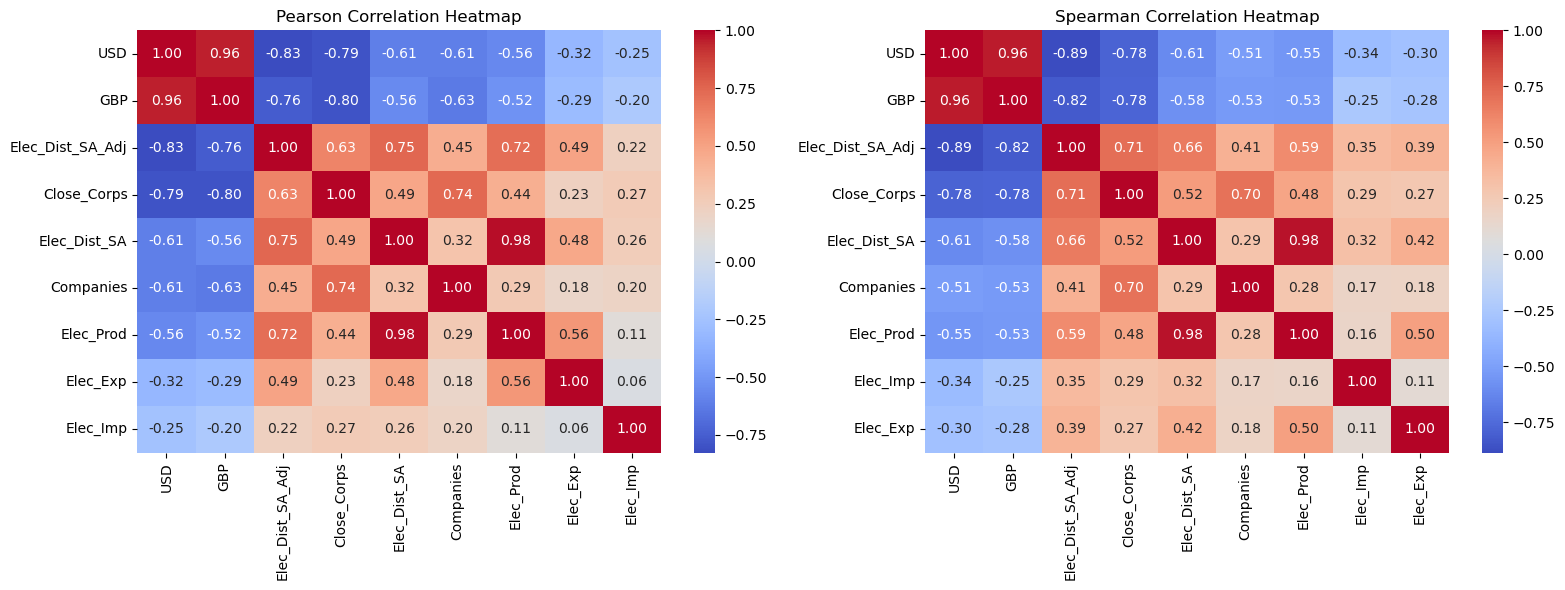

In [285]:
toppearson, topspearman = CorrelationCreation(['CPI Headline']+X.columns.tolist(), merged)

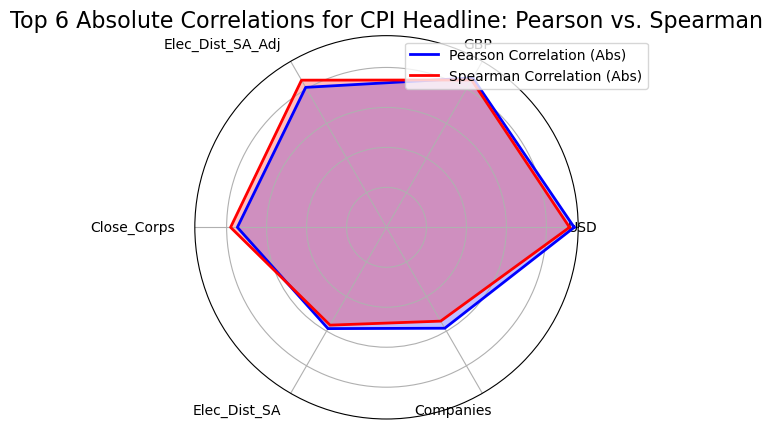

In [286]:
CreateRadarChart(['CPI Headline']+X.columns.tolist(), merged)

### So there are some good correlations, some that are now so good. Lets isolate the ones that are good and create a dataframe out of it. 

### Isolated Correlated Variables

- **USD**
- **GBP**
- **Elec_Dist_SA_Adj**
- **Close_Corps**
- **Elec_Dist_SA**
- **Companies**
- **Elec_Prod**


# Simple Forcasting Models

In [287]:
DataScienceDF = merged[['Date','CPI Headline','USD','GBP','Elec_Dist_SA_Adj','Close_Corps','Elec_Dist_SA','Companies','Elec_Prod']]

In [288]:
DataScienceDF.to_csv('DataScienceDF.csv', index=False)


So there are two methods that we can do:

Time Series Forcasting:

ARIMA (AutoRegressive Integrated Moving Average): Captures trends and seasonality but assumes a stationary process.
SARIMA (Seasonal ARIMA): Extends ARIMA to handle seasonality explicitly.
VAR (Vector AutoRegression): Useful when multiple time-dependent variables influence each other.

Secondally Hybrid Approaches: 

Nowcasting + ML: Forecast leading indicators (e.g., USD, GBP) using Prophet or ARIMA, then predict CPI with Random Forest/XGBoost.
Ensemble Models: Combine ARIMA/SARIMA with ML models for better predictions.

In [289]:
DataScienceDF.set_index('Date', inplace=True)
DataScienceDF = DataScienceDF.sort_index()

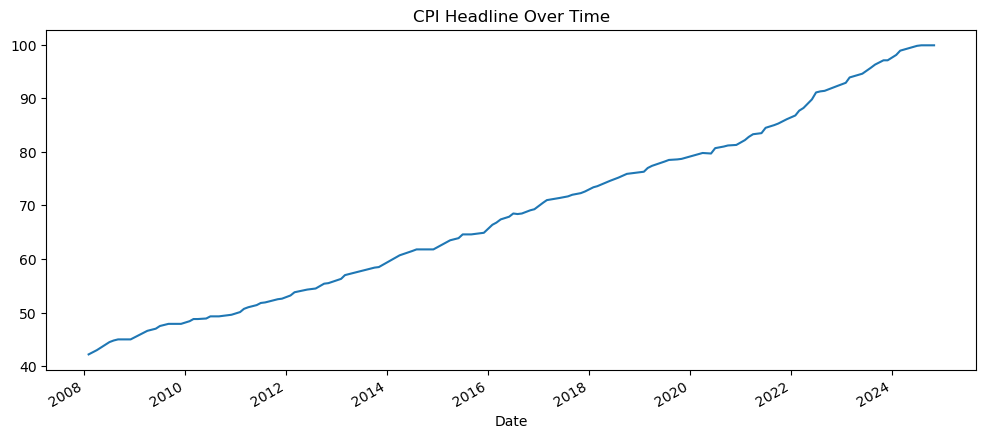

In [290]:
# Plot CPI Headline
DataScienceDF['CPI Headline'].plot(figsize=(12,5), title="CPI Headline Over Time")
plt.show()

In [291]:
# Check Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')

check_stationarity(DataScienceDF['CPI Headline'])


ADF Statistic: 1.568679947778087
p-value: 0.9977605036536689
Non-stationary


So it is Non-stationary which means that Arma wont work so well - there is seasonality

## ARIMA

                               SARIMAX Results                                
Dep. Variable:           CPI Headline   No. Observations:                   95
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -55.269
Date:                Sun, 09 Mar 2025   AIC                            116.537
Time:                        15:41:16   BIC                            124.167
Sample:                             0   HQIC                           119.619
                                 - 95                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    736.825      0.000       0.997       1.003
ma.L1         -0.9979      0.717     -1.393      0.164      -2.402       0.407
sigma2         0.1810      0.120      1.512      0.1

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/miniconda3/envs/financial/lib/python3.12/site-pack

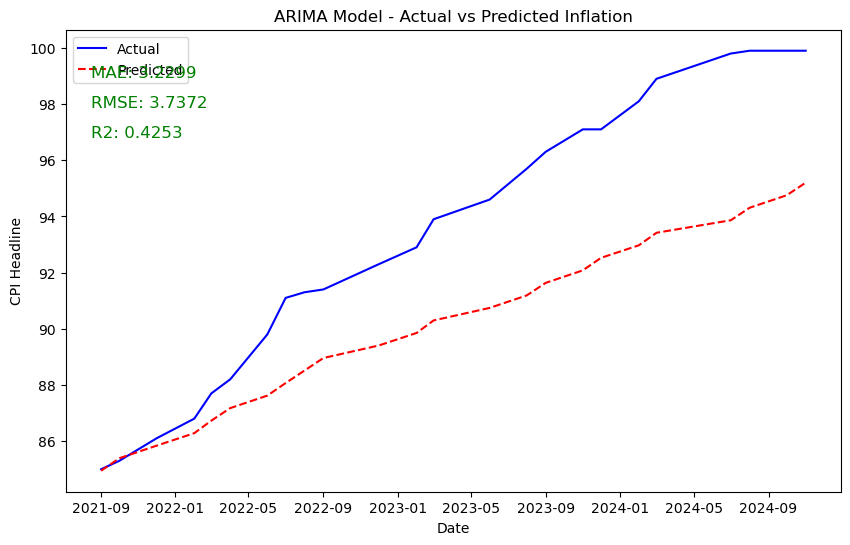

In [292]:
# Calculate the index for the 80/20 split
train_size = int(len(DataScienceDF) * 0.80)
train_data, test_data = DataScienceDF['CPI Headline'][:train_size], DataScienceDF['CPI Headline'][train_size:]

# Fit the ARIMA model on the training data
arima_model = ARIMA(train_data, order=(1,1,1))
arima_result = arima_model.fit()

# Print the summary of the ARIMA model
print(arima_result.summary())

# Make predictions on the test data
predictions = arima_result.forecast(steps=len(test_data))

# Calculate performance metrics
mae = mean_absolute_error(test_data, predictions)
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, predictions)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R2 Score: {r2}')

# Plotting Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='red', linestyle='--')
plt.title('ARIMA Model - Actual vs Predicted Inflation')
plt.xlabel('Date')
plt.ylabel('CPI Headline')
plt.legend()

# Add the metrics to the plot
plt.figtext(0.15, 0.8, f'MAE: {mae:.4f}', fontsize=12, color='green')
plt.figtext(0.15, 0.75, f'RMSE: {rmse:.4f}', fontsize=12, color='green')
plt.figtext(0.15, 0.7, f'R2: {r2:.4f}', fontsize=12, color='green')

plt.show()


## SARIMA

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                                     SARIMAX Results                                      
Dep. Variable:                       CPI Headline   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -50.627
Date:                            Sun, 09 Mar 2025   AIC                            111.253
Time:                                    15:41:17   BIC                            123.287
Sample:                                         0   HQIC                           116.085
                                             - 95                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9829      0.127     -7.753      0.000      -1.231      -0.734
ma.L1          0.8848      0.120   

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/miniconda3/envs/financial/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



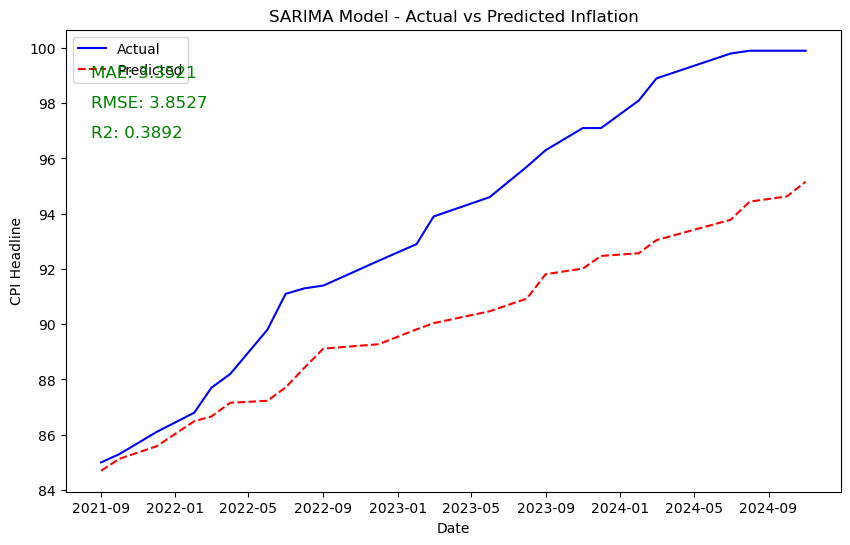

In [293]:
# Calculate the index for the 80/20 split
train_size = int(len(DataScienceDF) * 0.80)
train_data, test_data = DataScienceDF['CPI Headline'][:train_size], DataScienceDF['CPI Headline'][train_size:]

# Fit the SARIMA model on the training data
sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()

# Print the summary of the SARIMA model
print(sarima_result.summary())

# Make predictions on the test data
predictions = sarima_result.forecast(steps=len(test_data))

# Calculate performance metrics
mae = mean_absolute_error(test_data, predictions)
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, predictions)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R2 Score: {r2}')

# Plotting Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='red', linestyle='--')
plt.title('SARIMA Model - Actual vs Predicted Inflation')
plt.xlabel('Date')
plt.ylabel('CPI Headline')
plt.legend()

# Add the metrics to the plot
plt.figtext(0.15, 0.8, f'MAE: {mae:.4f}', fontsize=12, color='green')
plt.figtext(0.15, 0.75, f'RMSE: {rmse:.4f}', fontsize=12, color='green')
plt.figtext(0.15, 0.7, f'R2: {r2:.4f}', fontsize=12, color='green')

plt.show()


## Prophet

15:41:17 - cmdstanpy - INFO - Chain [1] start processing


15:41:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 5.031954787344137
Mean Squared Error (MSE): 29.706282126745357
Root Mean Squared Error (RMSE): 5.450346973060096
R2 Score: -0.24020564653873588


Text(0.15, 0.7, 'R2: -0.2402')

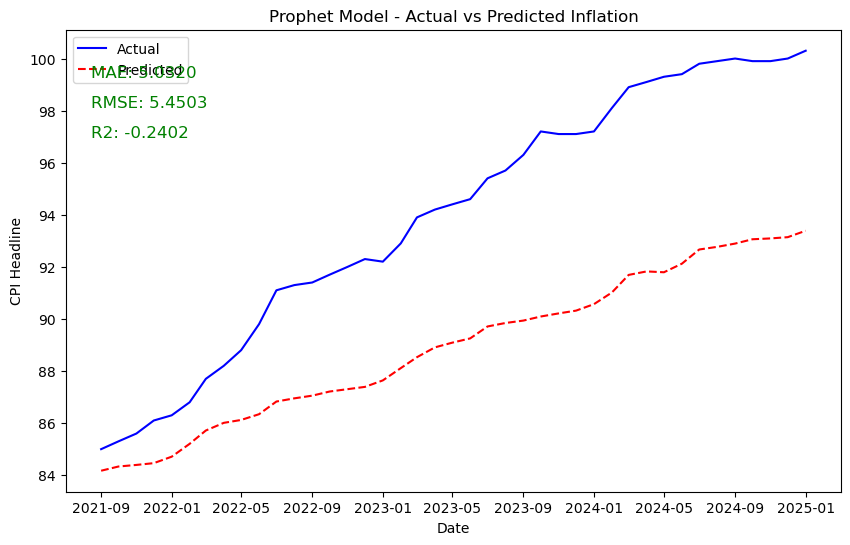

In [294]:
import pandas as pd
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare the data
ProfetDF = pivoted_df[['Date', 'CPI Headline']].copy()
ProfetDF = ProfetDF.rename(columns={'Date': 'ds', 'CPI Headline': 'y'})
ProfetDF['ds'] = pd.to_datetime(ProfetDF['ds'])  # Ensure datetime format



# Split into train/test (80/20)
train_size = int(len(ProfetDF) * 0.80)
train_data, test_data = ProfetDF[:train_size], ProfetDF[train_size:]

# Fit the Prophet model
ml = Prophet()
ml.fit(train_data)

# Create a future dataframe with the test period
future = test_data[['ds']]  # Use actual test set dates instead of generating future dates
result = ml.predict(future)

# Extract predictions
predictions = result['yhat'].values

# Calculate performance metrics
mae = mean_absolute_error(test_data['y'], predictions)
mse = mean_squared_error(test_data['y'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_data['y'], predictions)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R2 Score: {r2}')

# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red', linestyle='--')
plt.title('Prophet Model - Actual vs Predicted Inflation')
plt.xlabel('Date')
plt.ylabel('CPI Headline')
plt.legend()

# Add the metrics to the plot
plt.figtext(0.15, 0.8, f'MAE: {mae:.4f}', fontsize=12, color='green')
plt.figtext(0.15, 0.75, f'RMSE: {rmse:.4f}', fontsize=12, color='green')
plt.figtext(0.15, 0.7, f'R2: {r2:.4f}', fontsize=12, color='green')

